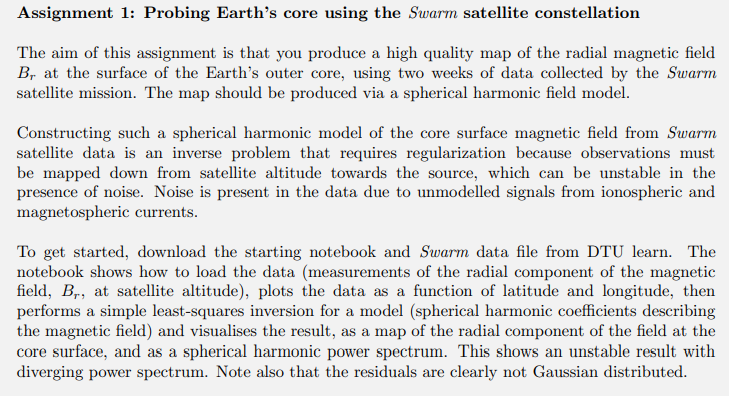

In [9]:
## Starting Notebook for Assignment 1: Robust Estimation and Sparsity regurlarization
## part of "Inverse Probelms and Machine Learning in Earth and Space Physics", MSc Course

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as spio
import cartopy.crs as ccrs
from matplotlib.colorbar import Colorbar
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# ChaosMagPy modules 
# Install with: pip install chaosmagpy
import chaosmagpy as cp
from chaosmagpy.model_utils import design_gauss

# Constants needed
a=6371.2     # Earth radius in km
c=3480.0       # Core radius in km

# Radius at which to evaluate SH Power spectra 
ps_r = c

# CMB plot limits in mT
limit = [-1,1]

# Load Swarm data file located in current directory
data = spio.loadmat("SW_B_14_28_Sept14_selected.mat")
d=data["Br"].reshape(-1,)  # Select radial field data
theta=data["theta"].reshape(-1,) #colatitude
phi=data["lambda"].reshape(-1,) # lambda is already used by Python, use phi instead - colongitude
r = data["r"].reshape(-1,)

## Plot function

In [3]:
# Global plot with polar areas
def plot_global(lon,lat,data,point_size,title="",cbar_label="",cmap=None,limit=None):
    if limit == None:
        limit = np.max(abs(data))
    else:
        limit = np.max(abs(np.array(limit)))
    # create figure
    fig = plt.figure(figsize=(9, 5))
    # make array of axes
    gs = fig.add_gridspec(2, 3, width_ratios=[1, 1, 1], height_ratios=[0.35, 0.65])
    axes = []
    axes.append(plt.subplot(gs[0, 0], projection=ccrs.NearsidePerspective(central_latitude=90.)))
    axes.append(plt.subplot(gs[0, 2], projection=ccrs.NearsidePerspective(central_latitude=-90.)))
    axes.append(plt.subplot(gs[1, :], projection=ccrs.Mollweide()))
    # Iterate over axes
    for ax in axes:
        pc = ax.scatter(lon, lat, c=data, s=point_size, cmap=cmap, vmin=-limit,
                           vmax=limit, transform=ccrs.PlateCarree())
        ax.gridlines(linewidth=0.5,
                     ylocs=np.linspace(-90, 90, num=7),  # parallels
                     xlocs=np.linspace(-180, 180, num=13),
                     color='grey', alpha=0.6, linestyle='-')  # meridians
        ax.coastlines(linewidth=0.5)
    # Add colorbar
    # inset axes into global map and move upwards
    cax = inset_axes(axes[-1], width="55%", height="10%", loc='upper center',
                     borderpad=-9)
    # use last artist for the colorbar
    clb = plt.colorbar(pc, cax=cax, extend='both', orientation='horizontal')
    clb.set_label('{}'.format(cbar_label), fontsize=12)
    
    #Title
    plt.suptitle("{}".format(title))
    #Adjust plot
    plt.subplots_adjust(top=0.985, bottom=0.015, left=0.008,
                        right=0.992, hspace=0.0, wspace=0.0)
    plt.show()

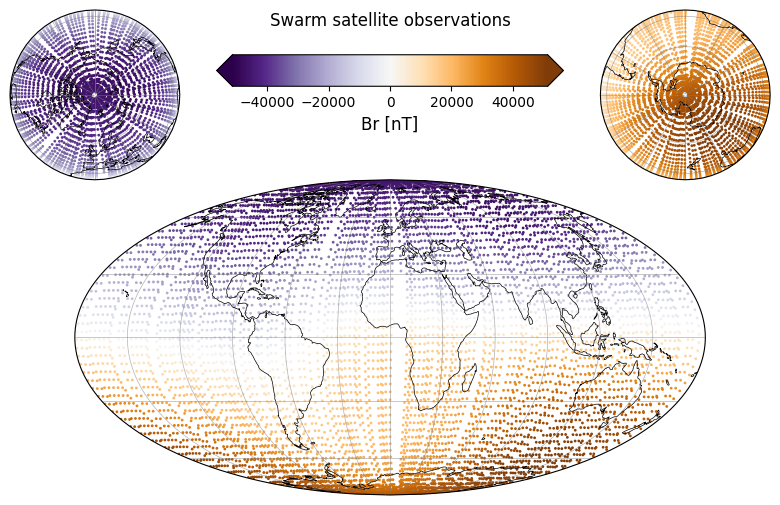

In [4]:
#  Plot simple map of B_r data
point_size = 1
plot_global(phi,90-theta,d,point_size,title="Swarm satellite observations",cbar_label="Br [nT]",cmap=plt.cm.PuOr_r)

In [5]:
# Set SH degree of model - DO NOT CHANGE!!!
N=20

# Design matrix for B_r at data location
Gr, _, _ = design_gauss(r,theta,phi,N) 

"""
design_gauss: Computes matrices to connect the radial, colatitude and azimuthal field
components to the magnetic potential field in terms of spherical harmonic
coefficients (Schmidt quasi-normalized)

Gr: design matrix

"""

# Setup Regularization Matrix 
# H_Br_cmb is linear operator matrix H for this problem, produces predictions of 
# the radial component of the magnetic field B_r on a grid at the CMB
# L2 norm (m^T H_Br_cmb^T H_Br_cmb m) approximates B_r^2 integrated over the CMB
# L1 norm approximate abs(H_Br_cmb m) integrated over the CMB

# The meshgrid size defines the size of H_Br_cmb, leading to matrices of size H_Br_cmb.shape[0] x H_Br_cmb.shape[0] 
# A very fine grid leads to a large memory footprint, so use a grid size you (and your machine) find suitable
# Here are some alternatives with decreasing memory requirements.
#phi_cmb, theta_cmb = np.meshgrid(np.linspace(-179., 179., num=180), np.linspace(1., 179., num=90)) # W_md: 16200x16200
#phi_cmb, theta_cmb = np.meshgrid(np.linspace(-178., 178., num=90), np.linspace(2., 178., num=45)) # W_md: 4050x4050
phi_cmb, theta_cmb = np.meshgrid(np.linspace(-177.5, 177.5, num=70), np.linspace(2.5, 177.5, num=36)) # W_md: 2520 x 2520

phi_cmb = phi_cmb.reshape(-1,)
theta_cmb = theta_cmb.reshape(-1,)
r_cmb = c*np.ones(theta_cmb.shape)

H_Br_cmb, _, _ = design_gauss(r_cmb,theta_cmb,phi_cmb,N)
R=H_Br_cmb.T@H_Br_cmb

In [6]:
# Gr_plot produces predictions of B_r at the CMB on a fine grid suitable for plotting
phi_plot, theta_plot = np.meshgrid(np.linspace(-179., 180., num=360), np.linspace(1., 179., num=180))
phi_plot = phi_plot.reshape(-1,)
theta_plot = theta_plot.reshape(-1,)
r_plot = c*np.ones(theta_plot.shape)

Gr_plot, _, _ = design_gauss(r_plot,theta_plot,phi_plot,N)

# Least squares inversion


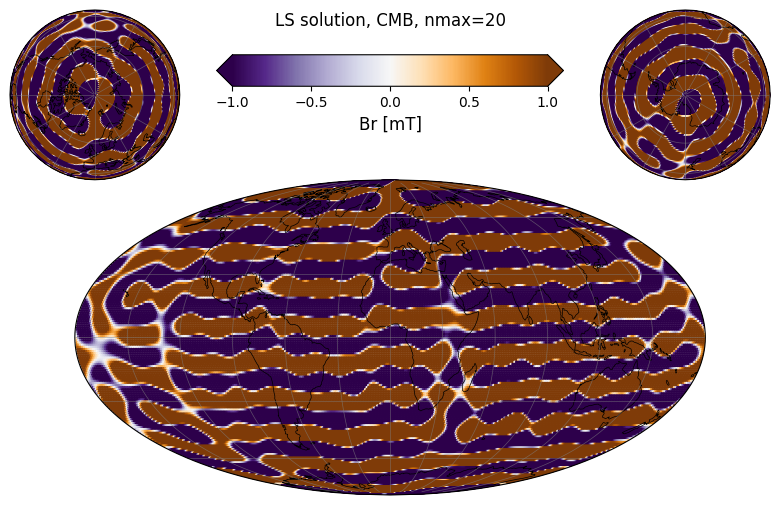

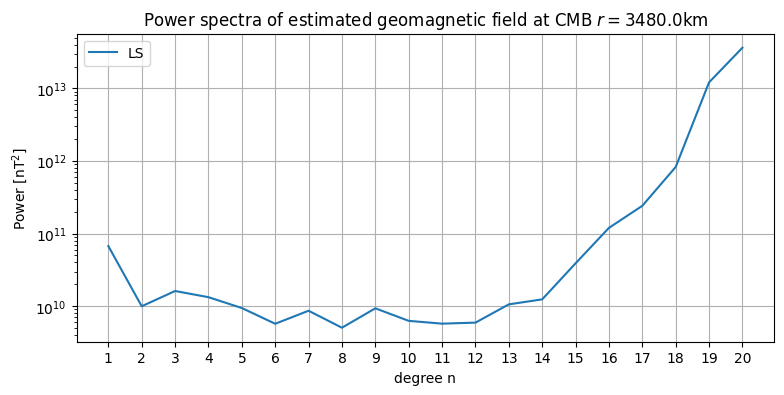

rms misfit: 12.0nT


In [7]:
# Least square inversion
m_ls = np.linalg.solve((Gr.T@Gr),Gr.T@d)

# SH power spectrum and Br on grid at CMB 
ps_ls = cp.model_utils.power_spectrum(m_ls,radius=ps_r)
Br_ls = Gr_plot@m_ls

# Plot map of B_r at CMB from least-squares solution (V. Poor: unphysical ringing/instability) 
plot_global(phi_plot,90-theta_plot,Br_ls*10**(-6),point_size,
            title="LS solution, CMB, nmax={}".format(N),cbar_label="Br [mT]",cmap=plt.cm.PuOr_r,limit=limit)

# Plot Power spectrum (Unphysical divergence at high SH degree)
n = np.arange(1,N+1)
plt.figure(figsize=(9,4))
plt.semilogy(n,ps_ls,label="LS")
plt.xlabel("degree n")
plt.ylabel(r"Power [nT$^2$]")
plt.title(r"Power spectra of estimated geomagnetic field at CMB $r={}$km".format(ps_r))
nmax = np.max([len(n)])
plt.xticks(np.arange(1,nmax+1))
plt.legend()
plt.grid()
plt.show()

# Residuals
r_ls=d-Gr@m_ls
# rms misfit
rms_resid_ls=np.sqrt(r_ls.T@r_ls/len(d))
print("rms misfit: {:.1f}nT".format(float(rms_resid_ls)))

# 1) Regularised LS (not Tikhonov!)


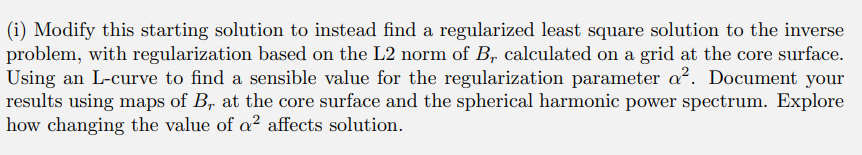


Regularised L2 norm :   
m_alpha = (G_t * G + a^2 * H_t * H)^-1 G_t * d

Find regularisation parameter - 2 approaches:
1) compute L-curve and find L-curve solution
2) use GCV



In [ ]:
## L-curve
alpha_sq_all, m_lc_smooth, model_norm_all, misfit_norm_all = [], [], [], []

start_alpha=1e2 # Start and end values are problem dependent - needs experimentation to find suitable range
end_alpha=1e-6
nsteps=100
alpha_power=np.geomspace(start_alpha,end_alpha,nsteps) # Geometrically spaced powers (equally spaced in log space)
for j in range(nsteps-1): 
    
    alpha_sq = alpha_power[j]
    alpha_sq_all.append(alpha_sq)  # This is current value of reg param
    
    #m_lc_smooth.append(np.linalg.lstsq((GTG+alpha_sq*R_time), G.T@d, rcond=None)[0])
    m_lc_smooth.append(np.linalg.solve((GTG+alpha_sq*R_time), G.T@d))

    
    d_pred=G@m_lc_smooth[j]
    res_lc_smooth=d-d_pred

    model_norm_all.append(m_lc_smooth[j]@R_time@m_lc_smooth[j])
    misfit_norm_all.append(np.linalg.norm(res_lc_smooth))
    
# Find alpha^2 via L-curve
# Locate L-curve corner and mark
alpha_sq_corner, i_corner, kappa = l_curve_corner(misfit_norm_all, model_norm_all, alpha_sq_all)

plt.figure(figsize = figsize)
plt.loglog(misfit_norm_all, model_norm_all)
plt.loglog(misfit_norm_all[i_corner], model_norm_all[i_corner],'or', fillstyle='none', markersize=10)
plt.xlabel('log (Misfit norm)')
plt.ylabel('log (Model norm)')
plt.title('L-curve, corner at '+r'$\alpha^2={:.3f}$'.format(alpha_sq_corner))
plt.show()